In [1]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner


In [70]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e15-LLRR.dat')
binned = binning(dt,sec=10)

def binPlot(Type='sec'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

In [96]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if 0 < m < 1 and .5 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [87]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [195]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


0.03127089887631981 1.1178088761642857


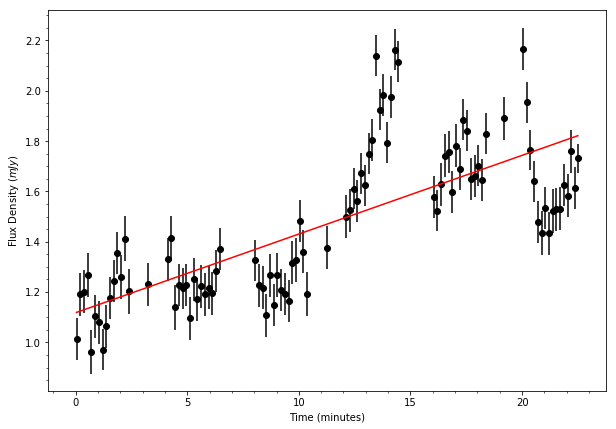

In [194]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e15_linearModel.png')
plt.show()

In [97]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)
linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[0.02988258, 1.15400749],
        [0.03354941, 1.09866453],
        [0.03164566, 1.1137207 ],
        [0.03242634, 1.12280803],
        [0.03249891, 1.10047326],
        [0.03118703, 1.11168077],
        [0.03282631, 1.10012637],
        [0.02997247, 1.1407364 ],
        [0.03156501, 1.11352189],
        [0.03112751, 1.12310905],
        [0.03282477, 1.09319633],
        [0.0313166 , 1.11669737],
        [0.03021386, 1.13423654],
        [0.03203021, 1.10327927],
        [0.03102486, 1.13503201],
        [0.02933585, 1.13906146],
        [0.0298477 , 1.13032847],
        [0.03123542, 1.12492396],
        [0.03157187, 1.11868721],
        [0.03045181, 1.11391939],
        [0.02901145, 1.15604337],
        [0.03063137, 1.11891277],
        [0.02981851, 1.14323439],
        [0.02913984, 1.14432168],
        [0.03121839, 1.11372721],
        [0.03130031, 1.11436732],
        [0.03145918, 1.12385506],
        [0.03171632, 1.10457321],
        [0.03165598, 1.12161108],
        [0.029

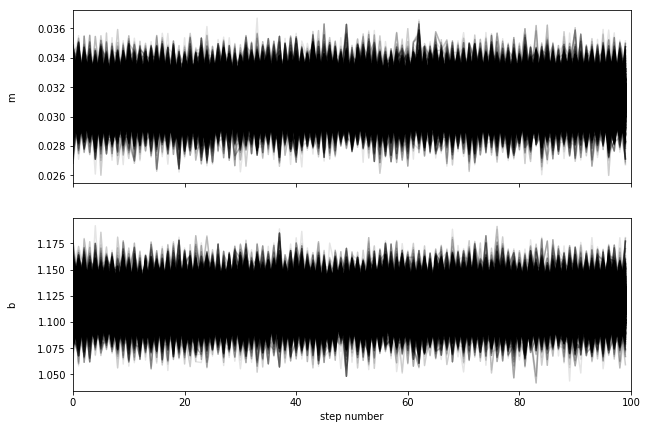

In [196]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e15_linearTrace.png')
plt.show()

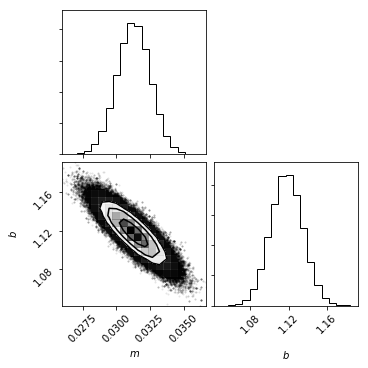

In [99]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/linearCorner.png')
plt.show()

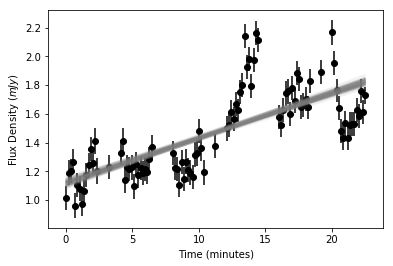

In [197]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e15_500mcmc_data.png')
plt.show()

In [102]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

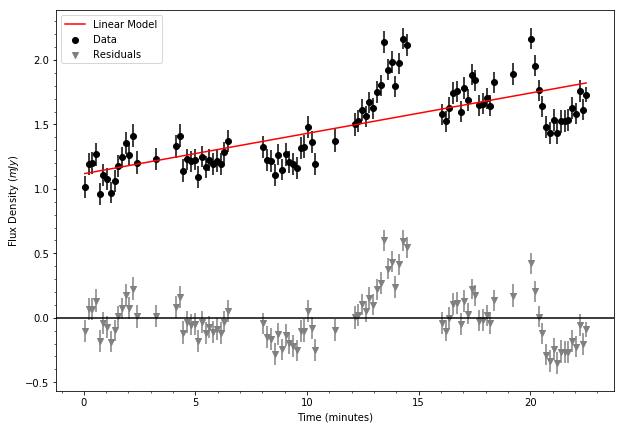

In [198]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,7))
plt.scatter(x,y,color='k',marker='o',label='Data')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='_nolegend_')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.scatter(x,linear_resid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e15_linearModel_fit.png')
plt.show()

In [183]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/92

5.775938312977119

## Fitting an logistic function


In [47]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if 0 < l < 2.5 and -5 < k < 10 and 9 < x0 < 15 and 1.0 < y0 < 1.4:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [50]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

0.5192003873703849 3.023579289406079 12.096674302586715 1.2203493398354257


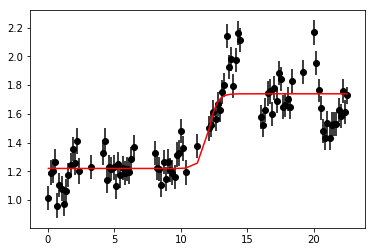

In [169]:
binPlot(Type='minutes')
plt.plot(x,logModel([l_ml,k_ml,x0_ml,y0_ml],x),color='red')
plt.show()

In [52]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[ 0.50169911,  2.63229524, 11.8932033 ,  1.23981219],
        [ 0.53248259,  1.7407298 , 11.36393174,  1.2012586 ],
        [ 0.49572212,  2.39506348, 12.0119062 ,  1.23022371],
        [ 0.54103407,  1.63108555, 10.94980932,  1.19994351],
        [ 0.50628238,  4.33302454, 12.11076815,  1.22260893],
        [ 0.53549103,  4.08434468, 12.14741017,  1.21078417],
        [ 0.5200875 ,  2.5842973 , 12.08600681,  1.21431452],
        [ 0.54594598,  3.08286666, 12.40136761,  1.2161231 ],
        [ 0.5308649 ,  5.39815697, 12.16539432,  1.21104955],
        [ 0.50289026,  3.50782729, 12.01211361,  1.22302032],
        [ 0.53760685,  6.84022572, 12.10128642,  1.22020023],
        [ 0.50838427,  2.28794014, 12.02180299,  1.23440053],
        [ 0.53457949,  2.97691459, 12.32491088,  1.20915069],
        [ 0.48979823,  3.18603993, 11.72213886,  1.22427348],
        [ 0.50138442,  2.61560598, 12.17844404,  1.2305789 ],
        [ 0.51849377,  1.96441997, 11.84293841,  1.21159986],
        

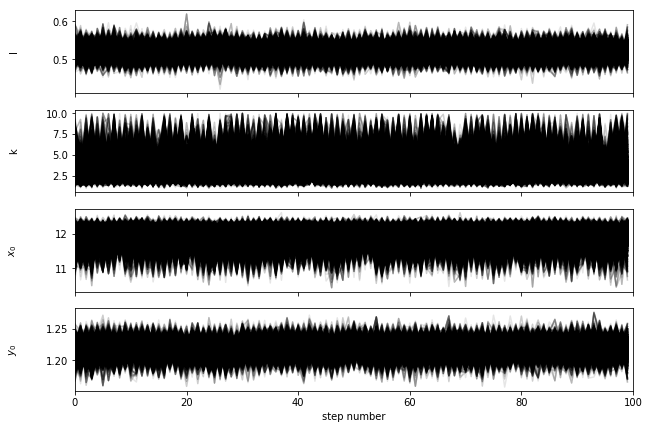

In [192]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('1314e15_Trace.png')
plt.show()

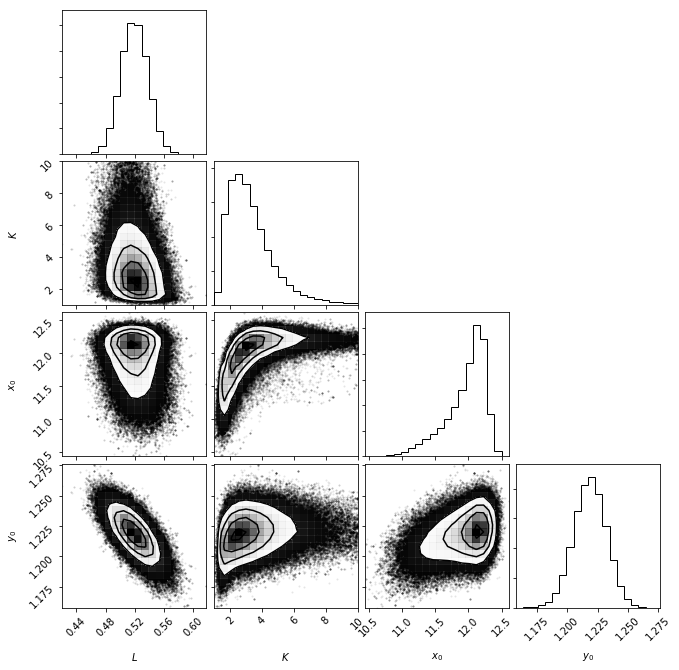

In [193]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/e15_logCorner.png')
plt.show()

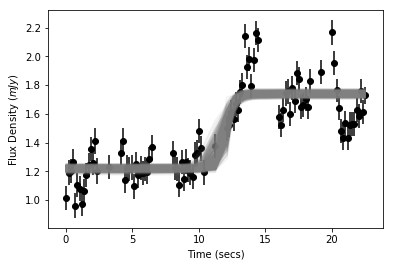

In [173]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/500mcmc_log.png')
plt.show()

In [175]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

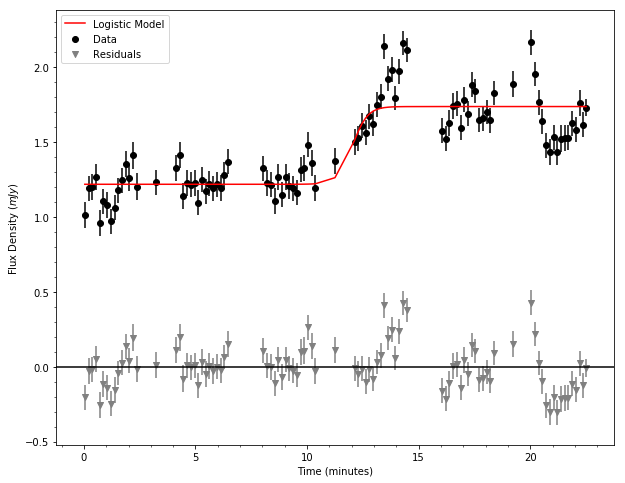

In [200]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(10,8))
binPlot(Type='minutes')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/e15_logModel.png')
plt.show()

In [106]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/90

3.3781324132641504

## e15 Looking at Stokes I, V and circular polarization

In [110]:
rr = pd.read_table('1314/2M1314e15-RR.dat')
ll = pd.read_table('1314/2M1314e15-LL.dat')

rr = binning(rr,10)
ll = binning(ll,10)

In [118]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

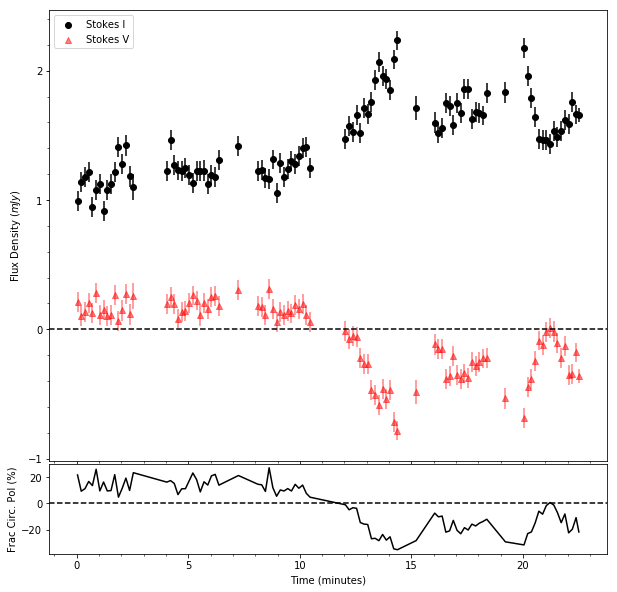

In [207]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.savefig('plots/e15_stokes.png')
plt.show()

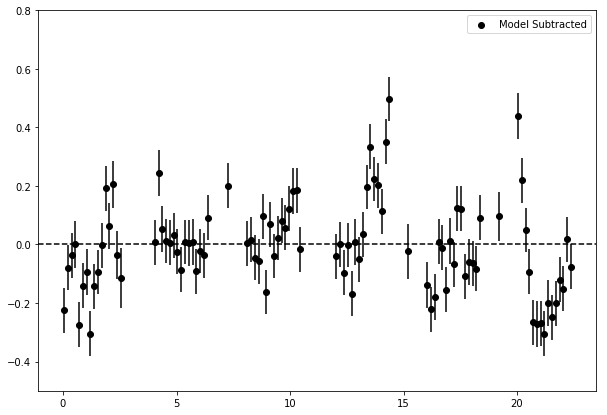

In [199]:
modelSub = stI - log_model

plt.figure(figsize=(10,7))
plt.scatter(time,modelSub,color='k',marker='o',label='Model Subtracted')
plt.errorbar(time,modelSub,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.ylim(-0.5,0.8)
plt.legend(loc='best')
plt.show()

In [37]:
high = pd.read_table('1314/2M1314e15-7GHz.dat')
low = pd.read_table('1314/2M1314e15-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10)
low = binning(low,10)


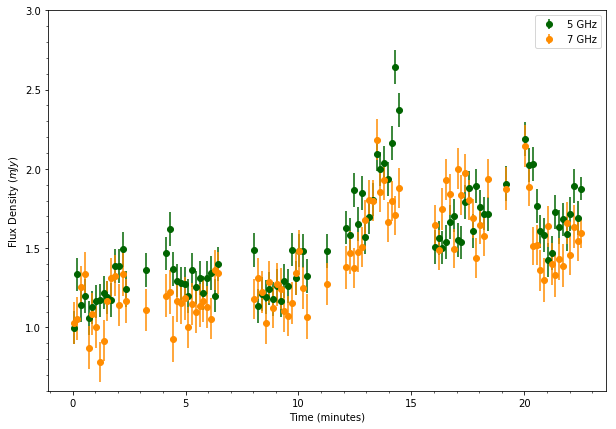

In [43]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',linestyle='None',color='darkgreen',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='o',linestyle='None',color='darkorange',label='7 GHz')
plt.legend(loc='best')
plt.ylim(0.6,3)
plt.minorticks_on()
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.show()